In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy import linalg
EPSILON = 1.1920929e-07
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import scanpy as sc
import pandas as pd
import spatialdm as sdm
import squidpy as sq
import tqdm
import adjustText
from scipy.optimize import minimize, minimize_scalar
from sklearn.neighbors import NearestNeighbors
import importlib

In [2]:
import warnings
import networkx as nx

# Silencing FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
import sys
sys.path.append("/Users/hs0424/Workspace/copulacci/src/copulacci/")
import cci
import spatial
import model
import simulation

/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
adata = sc.read_h5ad('data/human_breast_visium/adata.h5ad')

In [5]:
adata

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'old_annot_type', 'old_fine_annot_type', '1', '2', '3', '4', '5', 'scaled_x', 'scaled_y', 'fine_annot', 'annot', 'fine_annot_type', 'ground_truth', 'annot_type'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

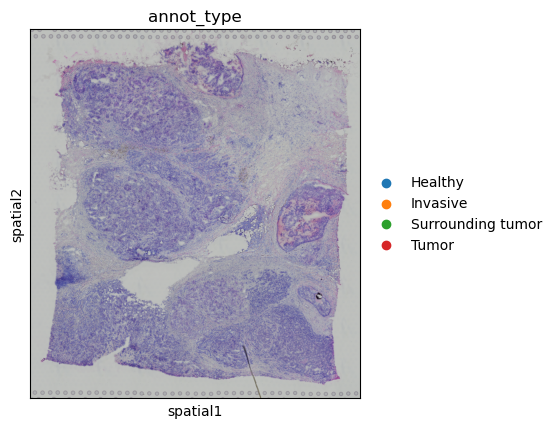

In [6]:
sc.pl.spatial(adata,  color='annot_type',spot_size=3)

In [7]:
sdm.extract_lr(adata, 'human', min_cell=20)

In [8]:
adata.obs['celltype'] = adata.obs.annot_type

In [26]:
df_lig_rec_linear = cci.extract_lig_rec_from_sdm(adata, allow_same_lr=True)
chosen_lr = list(set( df_lig_rec_linear.ligand.unique()).union(
    set( df_lig_rec_linear.receptor.unique() )
))
count_df = adata.raw.to_adata().to_df().loc[:,chosen_lr]

,LAMA4,CXCL1,TNFSF13,C3,GP1BB,CHRNB1,ACVR1B,LRRC4B,PLXNA2,PTHLH,...,GFRA4,ICOS,FGF22,RELN,NEGR1,WNT4,CCL8,CCL7,ITGB1,MDK
AAACAAGTATCTCCCA-1,1.0,0.0,2.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0
AAACACCAATAACTGC-1,3.0,0.0,1.0,5.0,1.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,13.0,17.0
AAACAGAGCGACTCCT-1,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
AAACAGGGTCTATATT-1,0.0,1.0,1.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,5.0
AAACAGTGTTCCTGGG-1,2.0,0.0,1.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,19.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,1.0,0.0,3.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0
TTGTTTCACATCCAGG-1,0.0,0.0,2.0,6.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,5.0,9.0
TTGTTTCATTAGTCTA-1,2.0,0.0,0.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,7.0
TTGTTTCCATACAACT-1,1.0,0.0,5.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,4.0


In [13]:
import importlib

In [16]:
importlib.reload(spatial)

<module 'spatial' from '/Users/hs0424/Workspace/copulacci/src/copulacci/spatial.py'>

In [17]:
int_edges_new, int_edges_with_selfloop = spatial.construct_boundary(
    adata,
    force_recalculate=True
)

Constructing spatial network with vanilla_visium
relabeling nodes


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3798/3798 [00:00<00:00, 5429.10it/s]


In [36]:
int_edges_with_selfloop.shape

(20280, 7)

In [18]:
df_lig_rec = pd.concat(
   [ adata.uns['ligand'], adata.uns['receptor']],
    axis = 1
)

In [38]:
lig_list = adata.uns['ligand'].values
rec_list = adata.uns['receptor'].values

In [39]:
data_list_dict, umi_sums, dist_list_dict = spatial.prepare_data_list(
    count_df,
    int_edges_with_selfloop,
    heteromeric=True,
    lig_list=lig_list,
    rec_list = rec_list,
    summarization='sum'
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.05s/it]


In [41]:
cop_df = model.run_copula(
    data_list_dict,
    umi_sums,
    DT=False,
    cutoff = 0.8,
    type_run='dense',
    num_restarts=2,
    df_lig_rec=df_lig_rec,
    heteronomic=True
)

Surrounding tumor=Surrounding tumor


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=20)]: Done  11 tasks      | elapsed:    0.5s
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
[Parallel(n_jobs=20)]: Done 199 tasks      | elapsed:   11.0s
[Parallel(n_jobs=20)]: Done 471 tasks      | elapsed:   20.5s
[Parallel(n_jobs=20)]: Done 1064 tasks      | elapsed:   29.9s
[Parallel(n_jobs=20)]: Done 1276 out of 1315 | elapsed:   31.9s remaining:    1.0s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:   35.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Invasive=Invasive


[Parallel(n_jobs=20)]: Done 320 tasks      | elapsed:   28.4s
[Parallel(n_jobs=20)]: Done 570 tasks      | elapsed:  1.1min
[Parallel(n_jobs=20)]: Done 1070 tasks      | elapsed:  1.5min
[Parallel(n_jobs=20)]: Done 1276 out of 1315 | elapsed:  1.6min remaining:    3.0s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:  1.8min finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
/Users/hs0424/miniforge3/envs/py

Healthy=Healthy


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/hs0424/miniforge3/env

Tumor=Tumor


[Parallel(n_jobs=20)]: Done 398 tasks      | elapsed:    9.2s
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
[Parallel(n_jobs=20)]: Done 696 tasks      | elapsed:   16.1s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:   23.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Surrounding tumor=Invasive


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
[Parallel(n_jobs=20)]: Done 440 tasks      | elapsed:    5.2s
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
[Parallel(n_jobs=20)]: Done 801 tasks      | elapsed:    8.0s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:   11.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Invasive=Surrounding tumor


[Parallel(n_jobs=20)]: Done 440 tasks      | elapsed:    5.1s
[Parallel(n_jobs=20)]: Done 851 tasks      | elapsed:    7.9s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:   10.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Tumor=Invasive


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    4.2s
[Parallel(n_jobs=20)]: Done 1168 tasks      | elapsed:    6.4s
[Parallel(n_jobs=20)]: Done 1276 out of 1315 | elapsed:    6.7s remaining:    0.2s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    7.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Invasive=Tumor


[Parallel(n_jobs=20)]: Done 440 tasks      | elapsed:    3.1s
[Parallel(n_jobs=20)]: Done 1256 tasks      | elapsed:    6.3s
[Parallel(n_jobs=20)]: Done 1276 out of 1315 | elapsed:    6.3s remaining:    0.2s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    6.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Tumor=Surrounding tumor


[Parallel(n_jobs=20)]: Done 440 tasks      | elapsed:    4.1s
[Parallel(n_jobs=20)]: Done 834 tasks      | elapsed:    6.9s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    9.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Surrounding tumor=Tumor


[Parallel(n_jobs=20)]: Done 440 tasks      | elapsed:    4.1s
[Parallel(n_jobs=20)]: Done 857 tasks      | elapsed:    6.6s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    8.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Healthy=Surrounding tumor


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    3.4s
[Parallel(n_jobs=20)]: Done 1276 out of 1315 | elapsed:    4.3s remaining:    0.1s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    5.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Surrounding tumor=Healthy


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    3.8s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    5.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Healthy=Invasive


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    3.9s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    5.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Invasive=Healthy


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    4.0s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    6.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Tumor=Healthy


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    4.7s
[Parallel(n_jobs=20)]: Done 1183 tasks      | elapsed:    6.6s
[Parallel(n_jobs=20)]: Done 1276 out of 1315 | elapsed:    7.0s remaining:    0.2s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    7.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Healthy=Tumor


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    4.5s
[Parallel(n_jobs=20)]: Done 1206 tasks      | elapsed:    6.4s
[Parallel(n_jobs=20)]: Done 1276 out of 1315 | elapsed:    6.7s remaining:    0.2s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    7.0s finished


In [48]:
cop_df_dict = cop_df

In [49]:
loc = adata.obsm['spatial']

loc_df = pd.DataFrame(loc).rename(columns = {0:"x", 1:"y"})
loc_df.loc[:,"cell"] = adata.obs_names
loc_df.set_index('cell', inplace=True)

In [100]:

from matplotlib.colors import Normalize



def plot_raw_lr_boundary_expression(
    lig_rec_idx,
    int_type,
    loc_df,
    int_edges_new,
    shrink_fraction = 1.0,
):
    lr_pairs_ct = int_edges_new.loc[
        int_edges_new.interaction == int_type,
        :
    ].copy()
    genes_to_show = lig_rec_idx.split("_")
    genes_to_show = [gene for gene in genes_to_show if gene in count_df.columns]
    
    #sns.scatterplot(data = int_loc_df, x = "x", y = "y", s = 8, hue='dist_from_z', ax=ax, alpha=0.8,label='start')
    selected_cells = list(
        set(lr_pairs_ct.cell1.unique()).union(
            lr_pairs_ct.cell2.unique()   
        )
    )
    
    fig, ax = plt.subplots(1,len(genes_to_show),
                           figsize=(5*len(genes_to_show),5))
    for i,gene in enumerate(genes_to_show):
        ax[i].scatter(loc_df['x'], loc_df['y'], c= "grey", s=0.4,alpha = 0.4)
        colors = np.array(count_df.loc[selected_cells, gene].values)
        tmp = loc_df.loc[selected_cells,:].copy()
        tmp.loc[:, 'gene'] = colors
        sns.scatterplot(x='x', y='y', hue='gene',
                             palette='Reds',s=10, 
                        data=tmp,alpha=0.7,ax= ax[i])

        norm = Normalize(tmp['gene'].min(), tmp['gene'].max())
        sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
        sm.set_array([])

        cbar = plt.colorbar(sm, ax=ax[i],shrink=shrink_fraction)
        # Remove the legend and add a colorbar
        ax[i].get_legend().remove()
        
    
        ax[i].set_title(gene + "\n" + int_type.replace('=',' → '))
        #ax[i].figure.colorbar(sm,ax=ax[i])
        ax[i].invert_yaxis()
        ax[i].set_xticks([])
        ax[i].set_yticks([]);
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['bottom'].set_visible(False)
        ax[i].spines['left'].set_visible(False)
    
        ax[i].set_xlabel("spatial1")
        ax[i].set_ylabel("spatial2")
    plt.tight_layout()
    plt.show()

In [111]:
def plot_lr_interaction_boundary_activity_color(
    df_lig_rec,
    lig_rec_idx,
    int_type,
    cop_df_dict,
    loc_df,
    int_edges_new,
    umi_sums,
    data_list_dict,
    dist_list_dict = None,
    shrink_fraction = 1.0,
):
    
    idx = df_lig_rec.index.get_loc(lig_rec_idx)
    g11, g12 = int_type.split('=')
    if dist_list_dict is None:
        
        row = cop_df_dict[int_type].loc[lig_rec_idx,:]
        coeff = row.copula_coeff
        mu_x = row.mu_x
        mu_y = row.mu_y
        loglikvec =  model.log_joint_lik_perm(
            [coeff,mu_x,mu_y],
            umi_sums[int_type][g11],
            umi_sums[int_type][g12],
            data_list_dict[int_type][idx][0],
            data_list_dict[int_type][idx][1],
            perm=20,
            DT=False,
            model='copula',
            return_sum=False
        )
        loglikvec = -loglikvec
    else:
        g11, g12 = int_name.split('=')
        row = cop_df_dict[int_type].loc[lig_rec_idx,:]
        rho_zero = row.rho_zero
        rho_one = row.rho_one
        mu_x = row.mu_x
        mu_y = row.mu_y
        loglikvec =  model.log_joint_lik_perm_dist(
            [rho_zero,rho_one,mu_x,mu_y],
            umi_sums[int_type][g11],
            umi_sums[int_type][g12],
            data_list_dict[int_type][idx][0],
            data_list_dict[int_type][idx][1],
            dist_list_dict[int_name],
            perm=20,
            DT=False,
            model='copula',
            return_sum=False
        )
        loglikvec = -loglikvec
        
    lr_pairs_ct = int_edges_new.loc[
        int_edges_new.interaction == int_type,
        :
    ].copy()
    fig, ax = plt.subplots(figsize=(6,6))
    cmap = plt.get_cmap('Reds')
    norm = Normalize(vmin=min(loglikvec), vmax=max(loglikvec))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([]) 
    # Remove the legend and add a colorbar
    ax.scatter(loc_df['x'], loc_df['y'], c= "grey",
               s=0.4,alpha = 0.4)
    #sns.scatterplot(data = int_loc_df, x = "x", y = "y", s = 8, hue='dist_from_z', ax=ax, alpha=0.8,label='start')
    
    for i,edge in enumerate(lr_pairs_ct[['cell1', 'cell2']].values):
        color = cmap(norm(loglikvec[i]))
        x1, y1 = loc_df.loc[  edge[0], 'x' ], loc_df.loc[  edge[0], 'y' ]
        x2, y2 = loc_df.loc[  edge[1], 'x' ], loc_df.loc[  edge[1], 'y' ]
        ax.plot([x1, x2], [y1, y2], color=color, marker='o', 
                linestyle='-', markersize=0.5,linewidth=1)
    cbar = plt.colorbar(sm, ax=ax,shrink=shrink_fraction,
                        label='Loglikelihood')
    #ax.get_legend().remove()
    ax.set_title(lig_rec_idx + "\n" + int_type.replace('=',' → '))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.gca().invert_yaxis()
    plt.gca().set_xticks([])
    plt.gca().set_yticks([]);
    plt.xlabel("spatial1")
    plt.ylabel("spatial2")

In [131]:
def plot_lr_edges_ct(
    ct,
    loc_df,
    int_edges_new,
    
):
    idx = df_lig_rec.index.get_loc(lig_rec_idx)
    g11, g12 = int_type.split('=')
   
    lr_pairs_ct = int_edges_new.loc[
         (int_edges_new.celltype2 == ct),
        :
    ].copy()
    fig, ax = plt.subplots(figsize=(5,6))
    
    # Remove the legend and add a colorbar
    ax.scatter(loc_df['x'], loc_df['y'], c= "grey",
               s=0.4,alpha = 0.4)
    #sns.scatterplot(data = int_loc_df, x = "x", y = "y", s = 8, hue='dist_from_z', ax=ax, alpha=0.8,label='start')
    
    for i,edge in enumerate(lr_pairs_ct[['cell1', 'cell2']].values):
        
        x1, y1 = loc_df.loc[  edge[0], 'x' ], loc_df.loc[  edge[0], 'y' ]
        x2, y2 = loc_df.loc[  edge[1], 'x' ], loc_df.loc[  edge[1], 'y' ]
        ax.plot([x1, x2], [y1, y2], color='black',
                linestyle='-', markersize=0.5,linewidth=1)
    
    #ax.get_legend().remove()
    ax.set_title('ALL → '+ct)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.gca().invert_yaxis()
    plt.gca().set_xticks([])
    plt.gca().set_yticks([]);
    plt.xlabel("spatial1")
    plt.ylabel("spatial2")

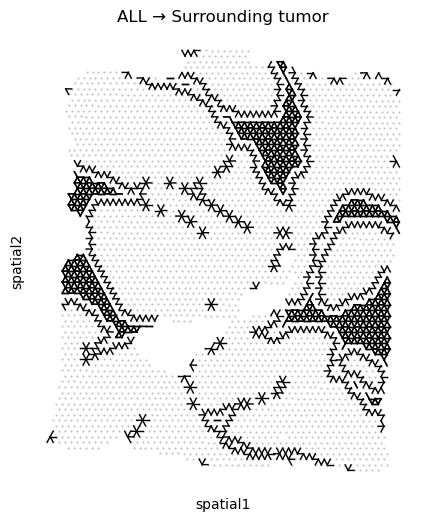

In [132]:
plot_lr_edges_ct(
    'Surrounding tumor',
    loc_df,
    int_edges_new
)

In [101]:
lig_rec_idx = 'ARTN_GFRA3'
int_type = 'Tumor=Surrounding tumor'


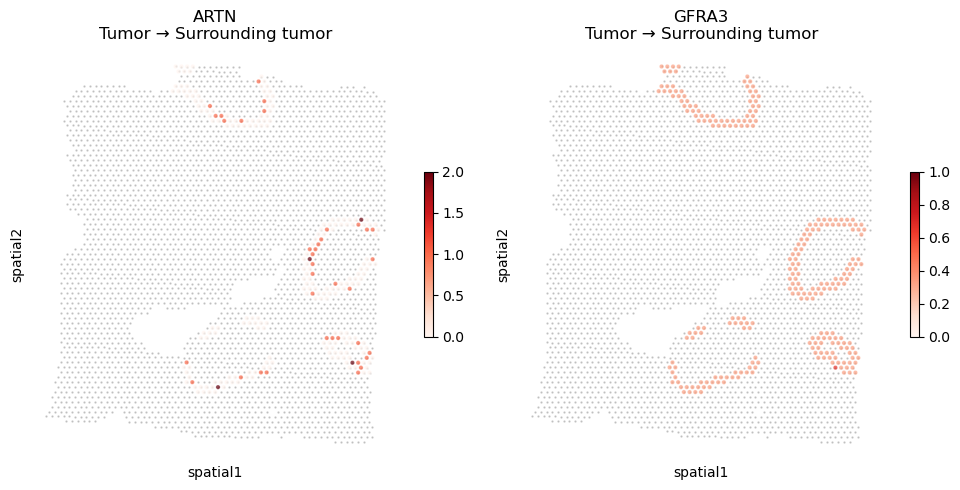

In [107]:
plot_raw_lr_boundary_expression(
    lig_rec_idx,
    int_type,
    loc_df,
    int_edges_new,
    shrink_fraction=0.4
)

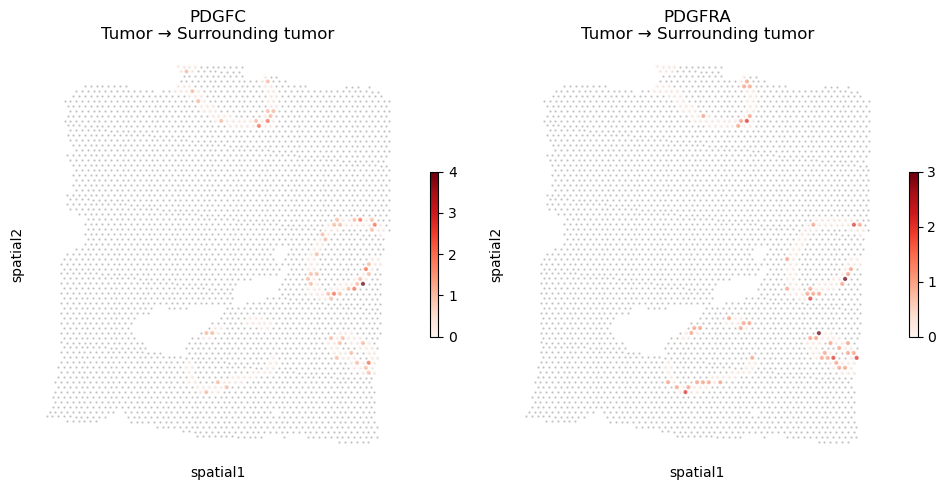

In [109]:
lig_rec_idx = 'PDGFC_PDGFRA'
plot_raw_lr_boundary_expression(
    lig_rec_idx,
    int_type,
    loc_df,
    int_edges_new,
    shrink_fraction=0.4
)

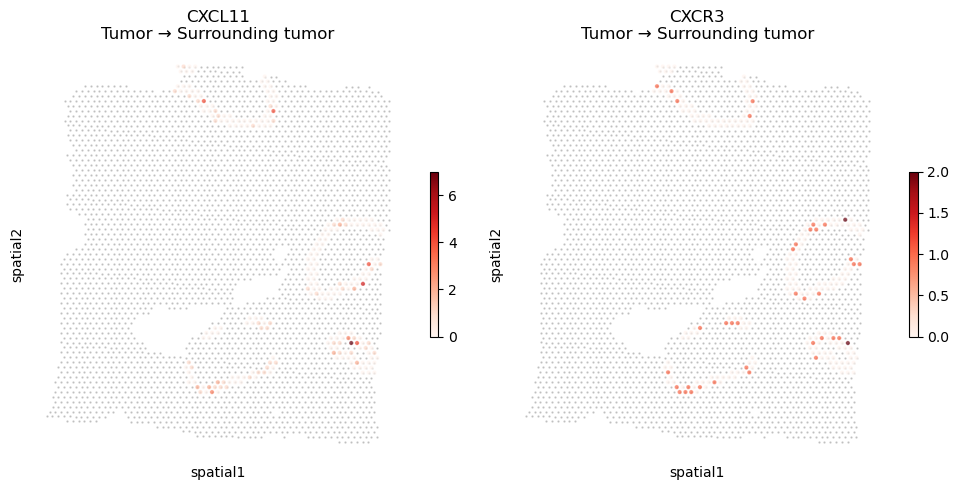

In [110]:
lig_rec_idx =  'CXCL11_CXCR3'
plot_raw_lr_boundary_expression(
    lig_rec_idx,
    int_type,
    loc_df,
    int_edges_new,
    shrink_fraction=0.4
)

In [90]:
def plot_lr_scatter(
    df_lig_rec,
    lig_rec_idx,
    int_type,
    data_list_dict,
):
    
    idx = df_lig_rec.index.get_loc(lig_rec_idx)
    lig,rec = lig_rec_idx.split('_')[:2]
    g11, g12 = int_type.split('=')
    x = data_list_dict[int_type][idx][0]
    y = data_list_dict[int_type][idx][1]
    _, ax = plt.subplots(1,1,figsize=(3,3))
    plt.scatter(x,y,s=20,c='black',alpha=0.8)
    plt.xlabel(lig,fontsize=15)
    plt.ylabel(rec,fontsize=15)
    sns.despine()
    plt.show()

In [133]:
def plot_lr_3d_hist(
    df_lig_rec,
    lig_rec_idx,
    int_type,
    data_list_dict,
):
    
    idx = df_lig_rec.index.get_loc(lig_rec_idx)
    lig,rec = lig_rec_idx.split('_')[:2]
    g11, g12 = int_type.split('=')
    x = data_list_dict[int_type][idx][0]
    y = data_list_dict[int_type][idx][1]
    fig = plt.figure()          #create a canvas, tell matplotlib it's 3d
    ax = fig.add_subplot(111, projection='3d')
    
    #make histogram stuff - set bins - I choose 20x20 because I have a lot of data
    hist, xedges, yedges = np.histogram2d(x, y, bins=(20,20))
    xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])
    
    xpos = xpos.flatten()/2.
    ypos = ypos.flatten()/2.
    zpos = np.zeros_like (xpos)
    
    dx = xedges [1] - xedges [0]
    dy = yedges [1] - yedges [0]
    dz = hist.flatten()
    
    cmap = plt.cm.get_cmap('Reds') # Get desired colormap - you can change this!
    max_height = np.max(dz)   # get range of colorbars so we can normalize
    min_height = np.min(dz)
    # scale each z to [0,1], and get their rgb values
    rgba = [cmap((k-min_height)/max_height) for k in dz] 
    
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')
    plt.xlabel(lig,fontsize=15)
    plt.ylabel(rec,fontsize=15)

/var/folders/g1/3dtmjp_93t98h_hcw8xs6l5w0000gn/T/ipykernel_83602/379649222.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds') # Get desired colormap - you can change this!


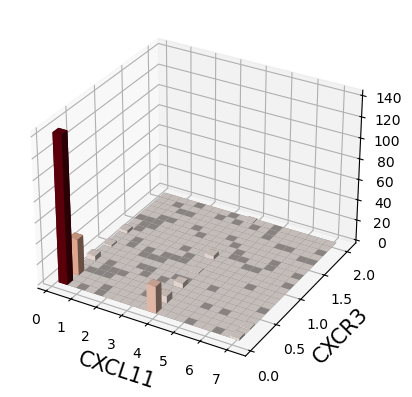

In [134]:
lig_rec_idx = 'CXCL11_CXCR3'
plot_lr_3d_hist(
    df_lig_rec,
    lig_rec_idx,
    int_type,
    data_list_dict,
)

/var/folders/g1/3dtmjp_93t98h_hcw8xs6l5w0000gn/T/ipykernel_83602/379649222.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds') # Get desired colormap - you can change this!


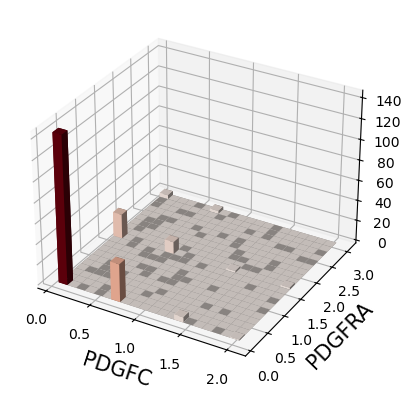

In [135]:
lig_rec_idx = 'PDGFC_PDGFRA'
plot_lr_3d_hist(
    df_lig_rec,
    lig_rec_idx,
    int_type,
    data_list_dict,
)

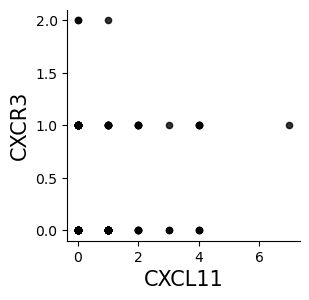

In [91]:
lig_rec_idx = 'CXCL11_CXCR3'
plot_lr_scatter(
    df_lig_rec,
    lig_rec_idx,
    int_type,
    data_list_dict,
)

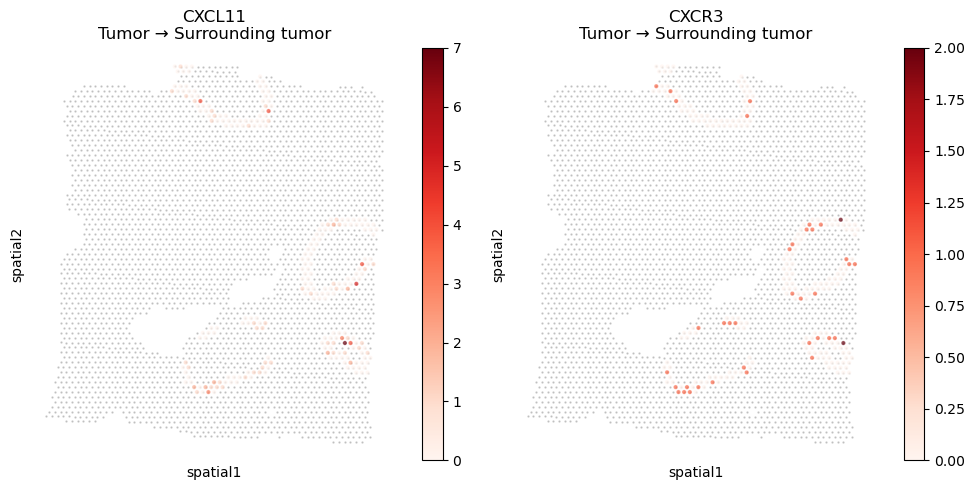

In [56]:
lig_rec_idx = 'CXCL11_CXCR3'
plot_raw_lr_boundary_expression(
    lig_rec_idx,
    int_type,
    loc_df,
    int_edges_new,
    shrink_fraction = 1.0
)

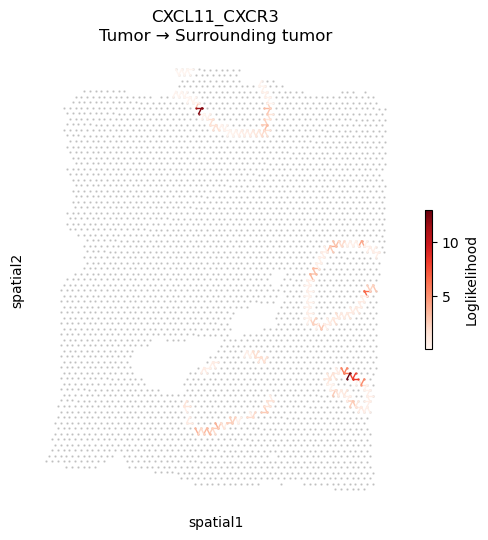

In [68]:
lig_rec_idx = 'CXCL11_CXCR3'
plot_lr_interaction_boundary_activity_color(
    df_lig_rec,
    lig_rec_idx,
    int_type,
    cop_df_dict,
    loc_df,
    int_edges_new,
    umi_sums,
    data_list_dict
)

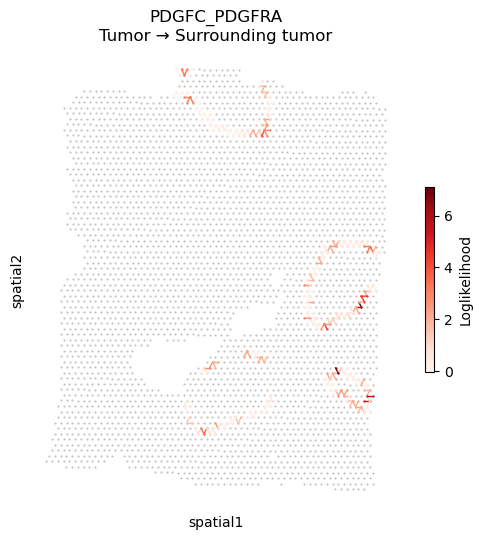

In [112]:
lig_rec_idx = 'PDGFC_PDGFRA'
plot_lr_interaction_boundary_activity_color(
    df_lig_rec,
    lig_rec_idx,
    int_type,
    cop_df_dict,
    loc_df,
    int_edges_new,
    umi_sums,
    data_list_dict,
    shrink_fraction=0.4
)

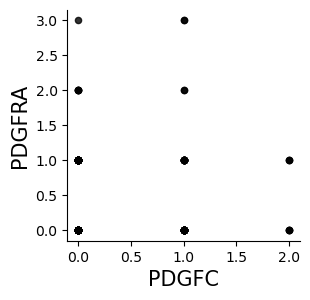

In [92]:
lig_rec_idx = 'PDGFC_PDGFRA'
plot_lr_scatter(
    df_lig_rec,
    lig_rec_idx,
    int_type,
    data_list_dict,
)

In [ ]:
lig_rec_idx = 'PDGFC_PDGFRA'
plot_raw_lr_boundary_expression(
    lig_rec_idx,
    int_type,
    loc_df,
    int_edges_new
)

In [30]:
genes_to_show

['ARTN', 'GFRA3']